# **Подготовка данных**

In [ ]:
import psycopg2
import pandas as pd
from google.colab import userdata

db_host = userdata.get('db_host')
db_port = userdata.get('db_port')
db_name = userdata.get('db_name')
db_user = userdata.get('db_user')
db_password = userdata.get('db_password')

connection = psycopg2.connect(
    host=db_host,
    port=db_port,
    database=db_name,
    user=db_user,
    password=db_password
)

tables = ["addresses", "developers", "offers", "offers_details", "realty_details", "realty_inside", "realty_outside"]

dfs = {}
for table in tables:
    query = f"SELECT * FROM public.{table};"
    dfs[table] = pd.read_sql(query, connection)

connection.close()

<ipython-input-35-4715df0c69e8>:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfs[table] = pd.read_sql(query, connection)


In [ ]:
import random
random.seed(42)

In [ ]:
# Addresses
dfs['addresses']['lat'] = dfs['addresses']['coordinates'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
dfs['addresses']['lng'] = dfs['addresses']['coordinates'].apply(lambda x: x['lng'] if isinstance(x, dict) else None)
dfs['addresses'].drop(columns=['id', 'coordinates', 'address', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# Developers
dfs['developers'].drop(columns=['id', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# offers
dfs['offers'] = dfs['offers'].dropna(subset=['photos_count'])
dfs['offers']['publication_at'] = pd.to_datetime(pd.to_datetime(dfs['offers']['publication_at'], unit = 's', utc = True).dt.date)
dfs['offers'].drop(columns=['id', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# offers_details
dfs['offers_details'] = dfs['offers_details'][dfs['offers_details']['agent_name'] != "Росимущество"].reset_index(drop=True)
dfs['offers_details'].drop(columns=['id', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# realty_details
dfs['realty_details']['finish_year'] = dfs['realty_details']['finish_date'].apply(lambda x: x.get('year') if isinstance(x, dict) else None)
# dfs['realty_details']['finish_quarter'] = dfs['realty_details']['finish_date'].apply(lambda x: x.get('quarter') if isinstance(x, dict) else None)
dfs['realty_details']['realty_type'] = dfs['realty_details']['realty_type'].replace('none', None)
dfs['realty_details']['heat_type'] = dfs['realty_details']['heat_type'].replace('none', None)
dfs['realty_details'].loc[dfs['realty_details']['finish_year'] <= 0, 'finish_year'] = None
# dfs['realty_details'].loc[dfs['realty_details']['finish_quarter'] <= 0, 'finish_quarter'] = None

dfs['realty_details'].drop(columns=['id', 'finish_date', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# realty_inside
dfs['realty_inside'].drop(columns=['id', 'created_at', 'updated_at'], inplace=True)

In [ ]:
# realty_outside
dfs['realty_outside']['material_type'] = dfs['realty_outside']['material_type'].replace('none', None)
dfs['realty_outside']['parking_type'] = dfs['realty_outside']['parking_type'].replace('none', None)

dfs['realty_outside'].drop(columns=['id', 'created_at', 'updated_at'], inplace=True)

In [ ]:
main_df = dfs['addresses'].merge(dfs['offers'], on='cian_id', how='inner').merge(dfs['offers_details'], on='cian_id', how='inner')

tables_to_left_join = ['developers', 'realty_details', 'realty_inside', 'realty_outside']
for table in tables_to_left_join:
    main_df = main_df.merge(dfs[table], on='cian_id', how='left')

In [ ]:
main_df.shape

(71092, 60)

In [ ]:
numeric_df = main_df.select_dtypes(include='number')
missing_values = numeric_df.isnull().sum().sort_values(ascending=False)
missing_values

,0
entrances,33748
cargo_lifts,32631
loggias,31209
foundation_year,30721
separated_wc,30660
total_rate,30292
review_count,30292
finish_year,30165
balconies,29882
buildings_count,29569


In [ ]:
print(main_df['deal_type'].unique())
print(main_df['parking_type'].unique())
print(main_df['windows_view'].unique())
print(main_df['garbage_chute'].unique())
print(main_df['realty_type'].unique())
print(main_df['heat_type'].unique())
print(main_df['gas_type'].unique())

['sale']
['ground' 'underground' None 'multilevel' 'open' 'roof']
['yardAndStreet' 'yard' None 'street']
[None True False]
['flat']
[None 'central' 'itp' 'autonomousBoiler' 'boiler' 'electric' 'without'
 'stove']
['unknown' 'without' None 'central' 'autonomous']


In [ ]:
import numpy as np
main_df = main_df[main_df['photos_count'] >= 0].reset_index(drop=True)

main_df['loggias'] = main_df['loggias'].replace({np.nan: 0})
main_df['separated_wc'] = main_df['separated_wc'].replace({np.nan: 0})
# main_df['finish_quarter'] = main_df['finish_quarter'].replace({np.nan: 0})
main_df['balconies'] = main_df['balconies'].replace({np.nan: 0})
main_df['combined_wc'] = main_df['combined_wc'].replace({np.nan: 0})
main_df['passenger_lifts'] = main_df['passenger_lifts'].replace({np.nan: 0})

main_df['total_rate'] = main_df['total_rate'].fillna(main_df['total_rate'].mean())
main_df['review_count'] = main_df['review_count'].fillna(main_df['review_count'].mean())
main_df['ceiling_height'] = main_df['ceiling_height'].fillna(main_df['ceiling_height'].mean())

mean_proportion_ceiling_height = (main_df['ceiling_height'] / main_df['total_area']).mean()
main_df.loc[main_df['ceiling_height'] <= 0, 'ceiling_height'] = main_df['total_area'] * mean_proportion_ceiling_height

mean_proportion_living_area = (main_df['living_area'] / main_df['total_area']).mean()
main_df['living_area'] = main_df['living_area'].fillna(main_df['total_area'] * mean_proportion_living_area)

mask = (main_df['total_area'] - main_df['living_area']) != 0
mean_proportion_kitchen_area = (main_df.loc[mask, 'kitchen_area'] / (main_df.loc[mask, 'total_area'] - main_df.loc[mask, 'living_area'])).mean()
main_df['kitchen_area'] = main_df['kitchen_area'].fillna((main_df['total_area'] - main_df['living_area']).replace(0, np.nan) * mean_proportion_kitchen_area)


mean_proportion_rooms_count = (main_df['rooms_count'] / main_df['living_area']).mean()
main_df['rooms_count'] = main_df['rooms_count'].fillna(main_df['living_area']*mean_proportion_rooms_count).astype(int)
main_df['build_year'] = main_df.apply(lambda row: row['finish_year'] if pd.isna(row['build_year']) else row['build_year'], axis=1)

main_df = main_df.dropna(subset=['travel_time', 'views_count', 'kitchen_area', 'build_year']).copy()
main_df.drop(columns=['entrances', 'cargo_lifts', 'foundation_year', 'buildings_count', 'lifts_count', 'finish_year'], inplace=True)


In [ ]:
main_df.shape

(68472, 54)

In [ ]:
numeric_df = main_df.select_dtypes(include='number')
missing_values = numeric_df.isnull().sum().sort_values(ascending=False)
missing_values

,0
cian_id,0
travel_time,0
build_year,0
combined_wc,0
separated_wc,0
rooms_count,0
loggias,0
balconies,0
ceiling_height,0
kitchen_area,0


In [ ]:
category_df = main_df.select_dtypes(include=['object'])
missing_values2 = category_df.isnull().sum().sort_values(ascending=False)
missing_values2

,0
is_penthouse,60150
garbage_chute,49760
project_type,37315
material_type,36077
heat_type,33274
is_reliable,28240
name,27717
is_emergency,26628
renovation_programm,26628
gas_type,26628


In [ ]:
main_df['is_penthouse'] = main_df['is_penthouse'].astype(bool).fillna(False)
main_df['garbage_chute'] = main_df['garbage_chute'].astype(bool).fillna(False)
main_df['is_reliable'] = main_df['is_reliable'].astype(bool).fillna(False)
main_df['is_emergency'] = main_df['is_emergency'].astype(bool).fillna(False)
main_df['is_apartment'] = main_df['is_apartment'].astype(bool).fillna(False)
main_df['is_mortgage_allowed'] = main_df['is_mortgage_allowed'].astype(bool).fillna(False)
main_df['renovation_programm'] = main_df['renovation_programm'].astype(bool).fillna(False)

main_df['photos_count'] = main_df['photos_count'].astype(int)
main_df['price'] = main_df['price'].astype(int)
main_df['travel_time'] = main_df['travel_time'].astype(int)
main_df['views_count'] = main_df['views_count'].astype(int)
main_df['balconies'] = main_df['balconies'].astype(int)
main_df['loggias'] = main_df['loggias'].astype(int)
main_df['separated_wc'] = main_df['separated_wc'].astype(int)
main_df['combined_wc'] = main_df['combined_wc'].astype(int)
main_df['passenger_lifts'] = main_df['passenger_lifts'].astype(int)
main_df['review_count'] = main_df['review_count'].astype(int)
main_df['build_year'] = main_df['build_year'].astype(int)

In [ ]:
main_df['project_type'] = main_df['project_type'].replace({np.nan: 'Индивидуальный проект'})

In [ ]:
import numpy as np

# Центр Москвы
center_lat = 55.753600
center_lng = 37.621184

# Радиус Земли в километрах
earth_radius_km = 6371

def haversine(lat1, lng1, lat2, lng2):
    # Преобразуем градусы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])

    dlat = lat2 - lat1
    dlng = lng2 - lng1

    # Формула Хаверсина
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earth_radius_km * c

# Добавление нового столбца в DataFrame
main_df['distance_from_center'] = haversine(main_df['lat'], main_df['lng'], center_lat, center_lng)


In [ ]:
main_df[['lat', 'lng', 'distance_from_center']]

,lat,lng,distance_from_center
0,55.979979,37.188178,36.926101
1,55.712710,37.644477,4.774909
2,55.893965,37.380651,21.664143
3,55.868526,37.681218,13.318349
4,55.693186,37.476913,11.258577
...,...,...,...
71087,55.709262,37.611374,4.968273
71088,55.571825,37.383200,25.126626
71089,55.728008,37.636033,2.993652
71090,55.554236,37.465838,24.215880


In [ ]:
main_df = main_df[main_df['is_duplicate'] != True]
main_df = main_df.drop(columns=['is_reliable','heat_type', 'name', 'gas_type', 'parking_type', 'windows_view','street', 'agent_name', 'house', 'is_duplicate', 'cian_id', 'lat', 'lng', 'price_changes', 'description'], axis=1)
main_df = main_df.dropna(subset=['district', 'county', 'sale_type'])

In [ ]:
mask = main_df['project_type'] != 'Индивидуальный проект'

main_df.loc[mask, 'material_type'] = main_df.loc[mask].groupby('project_type')['material_type'].transform(lambda x: x.ffill().bfill())

In [ ]:
main_df.loc[:, 'material_type'] = main_df['material_type'].fillna(main_df['material_type'].mode()[0])

In [ ]:
main_df['material_type'].unique()

array(['panel', 'monolith', 'brick', 'block', 'monolithBrick', 'stalin',
       'wood'], dtype=object)

In [ ]:
main_df.loc[:, 'repair_type'] = main_df['repair_type'].fillna(main_df['repair_type'].mode()[0])

In [ ]:
main_df.columns

Index(['county', 'district', 'metro', 'travel_type', 'travel_time', 'price',
       'category', 'views_count', 'photos_count', 'floor_number',
       'floors_count', 'publication_at', 'deal_type', 'flat_type', 'sale_type',
       'review_count', 'total_rate', 'realty_type', 'project_type',
       'is_apartment', 'is_penthouse', 'is_mortgage_allowed', 'is_premium',
       'is_emergency', 'renovation_programm', 'repair_type', 'total_area',
       'living_area', 'kitchen_area', 'ceiling_height', 'balconies', 'loggias',
       'rooms_count', 'separated_wc', 'combined_wc', 'build_year',
       'material_type', 'garbage_chute', 'passenger_lifts',
       'distance_from_center'],
      dtype='object')

In [ ]:
# Extract features from the 'publication_at' datetime column
main_df['publication_at'] = pd.to_datetime(main_df['publication_at'])
main_df['year'] = main_df['publication_at'].dt.year
main_df['month'] = main_df['publication_at'].dt.month
main_df['day_of_week'] = main_df['publication_at'].dt.dayofweek
main_df['day_of_month'] = main_df['publication_at'].dt.day

main_df = main_df.drop(columns=['publication_at'])

In [ ]:
main_df = main_df.applymap(lambda x: str(x) if isinstance(x, list) else x)

# Удаляем столбцы с единственным значением
main_df = main_df.loc[:, main_df.nunique() > 1]
main_df

<ipython-input-29-1185f8a003c4>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  main_df = main_df.applymap(lambda x: str(x) if isinstance(x, list) else x)


,county,district,metro,travel_type,travel_time,price,category,views_count,photos_count,floor_number,...,combined_wc,build_year,material_type,garbage_chute,passenger_lifts,distance_from_center,year,month,day_of_week,day_of_month
0,ЗелАО,Старое Крюково,Зеленоград — Крюково,walk,13,14000000,flatSale,228,21,9,...,0,2022,panel,False,1,36.926101,2024,11,4,1
1,ЮАО,Даниловский,Тульская,walk,25,70000000,flatSale,1183,5,8,...,2,2016,monolith,False,3,4.774909,2016,9,0,12
2,СЗАО,Куркино,Сходненская,transport,12,16900000,flatSale,3585,16,1,...,0,1920,panel,False,0,21.664143,2016,4,0,25
3,СВАО,Лосиноостровский,Бабушкинская,walk,14,66000000,flatSale,8408,36,6,...,2,2008,brick,True,1,13.318349,2016,11,0,7
4,ЗАО,Раменки,Мичуринский проспект,walk,12,58507560,newBuildingFlatSale,165,49,24,...,2,2025,panel,False,1,11.258577,2024,8,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71083,ЦАО,Замоскворечье,Павелецкая,walk,8,16500000,newBuildingFlatSale,200,5,15,...,1,2025,panel,False,1,3.193571,2024,12,6,1
71086,САО,Сокол,Сокол,walk,10,8950000,flatSale,568,39,12,...,1,2022,panel,True,4,9.230416,2024,12,6,1
71087,ЮАО,Даниловский,Тульская,walk,13,6990000,flatSale,513,28,1,...,1,1977,panel,True,1,4.968273,2024,12,6,1
71089,ЦАО,Замоскворечье,Павелецкая,walk,5,24000000,flatSale,199,3,2,...,1,1914,brick,False,1,2.993652,2024,12,6,1


In [ ]:
main_df.reset_index(drop=True)

,county,district,metro,travel_type,travel_time,price,category,views_count,photos_count,floor_number,...,combined_wc,build_year,material_type,garbage_chute,passenger_lifts,distance_from_center,year,month,day_of_week,day_of_month
0,ЗелАО,Старое Крюково,Зеленоград — Крюково,walk,13,14000000,flatSale,228,21,9,...,0,2022,panel,False,1,36.926101,2024,11,4,1
1,ЮАО,Даниловский,Тульская,walk,25,70000000,flatSale,1183,5,8,...,2,2016,monolith,False,3,4.774909,2016,9,0,12
2,СЗАО,Куркино,Сходненская,transport,12,16900000,flatSale,3585,16,1,...,0,1920,panel,False,0,21.664143,2016,4,0,25
3,СВАО,Лосиноостровский,Бабушкинская,walk,14,66000000,flatSale,8408,36,6,...,2,2008,brick,True,1,13.318349,2016,11,0,7
4,ЗАО,Раменки,Мичуринский проспект,walk,12,58507560,newBuildingFlatSale,165,49,24,...,2,2025,panel,False,1,11.258577,2024,8,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56897,ЦАО,Замоскворечье,Павелецкая,walk,8,16500000,newBuildingFlatSale,200,5,15,...,1,2025,panel,False,1,3.193571,2024,12,6,1
56898,САО,Сокол,Сокол,walk,10,8950000,flatSale,568,39,12,...,1,2022,panel,True,4,9.230416,2024,12,6,1
56899,ЮАО,Даниловский,Тульская,walk,13,6990000,flatSale,513,28,1,...,1,1977,panel,True,1,4.968273,2024,12,6,1
56900,ЦАО,Замоскворечье,Павелецкая,walk,5,24000000,flatSale,199,3,2,...,1,1914,brick,False,1,2.993652,2024,12,6,1


In [ ]:
for i in main_df.describe():
  print(main_df.describe()[i])

count    56902.000000
mean        11.140048
std          5.892863
min          1.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         52.000000
Name: travel_time, dtype: float64
count    5.690200e+04
mean     5.655484e+07
std      1.372726e+08
min      3.000000e+05
25%      1.270943e+07
50%      2.044851e+07
75%      4.490000e+07
max      6.450000e+09
Name: price, dtype: float64
count     56902.000000
mean        695.097536
std        2144.631469
min           0.000000
25%          16.000000
50%          62.500000
75%         418.000000
max      164396.000000
Name: views_count, dtype: float64
count    56902.000000
mean        17.696988
std          9.741346
min          1.000000
25%         11.000000
50%         16.000000
75%         23.000000
max         65.000000
Name: photos_count, dtype: float64
count    56902.000000
mean        10.058047
std          9.676583
min         -1.000000
25%          3.000000
50%          7.000000
75%         14.000000
max

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56902 entries, 0 to 71091
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county                56902 non-null  object 
 1   district              56902 non-null  object 
 2   metro                 56902 non-null  object 
 3   travel_type           56902 non-null  object 
 4   travel_time           56902 non-null  int64  
 5   price                 56902 non-null  int64  
 6   category              56902 non-null  object 
 7   views_count           56902 non-null  int64  
 8   photos_count          56902 non-null  int64  
 9   floor_number          56902 non-null  int64  
 10  floors_count          56902 non-null  int64  
 11  flat_type             56902 non-null  object 
 12  sale_type             56902 non-null  object 
 13  review_count          56902 non-null  int64  
 14  total_rate            56902 non-null  float64
 15  project_type          56

In [ ]:
main_df['floors_count']

182

# Выбросы

Где могут быть сильные выбросы:

price — Стоимость объекта часто содержит выбросы (например, слишком высокая или слишком низкая стоимость).

total_area, living_area, kitchen_area — Площади могут содержать аномально маленькие или большие значения.

balconies и loggias — Количество балконов и лоджий может быть неестественно большим.
rooms_count — Количество комнат также может содержать выбросы (например, слишком большое число комнат).


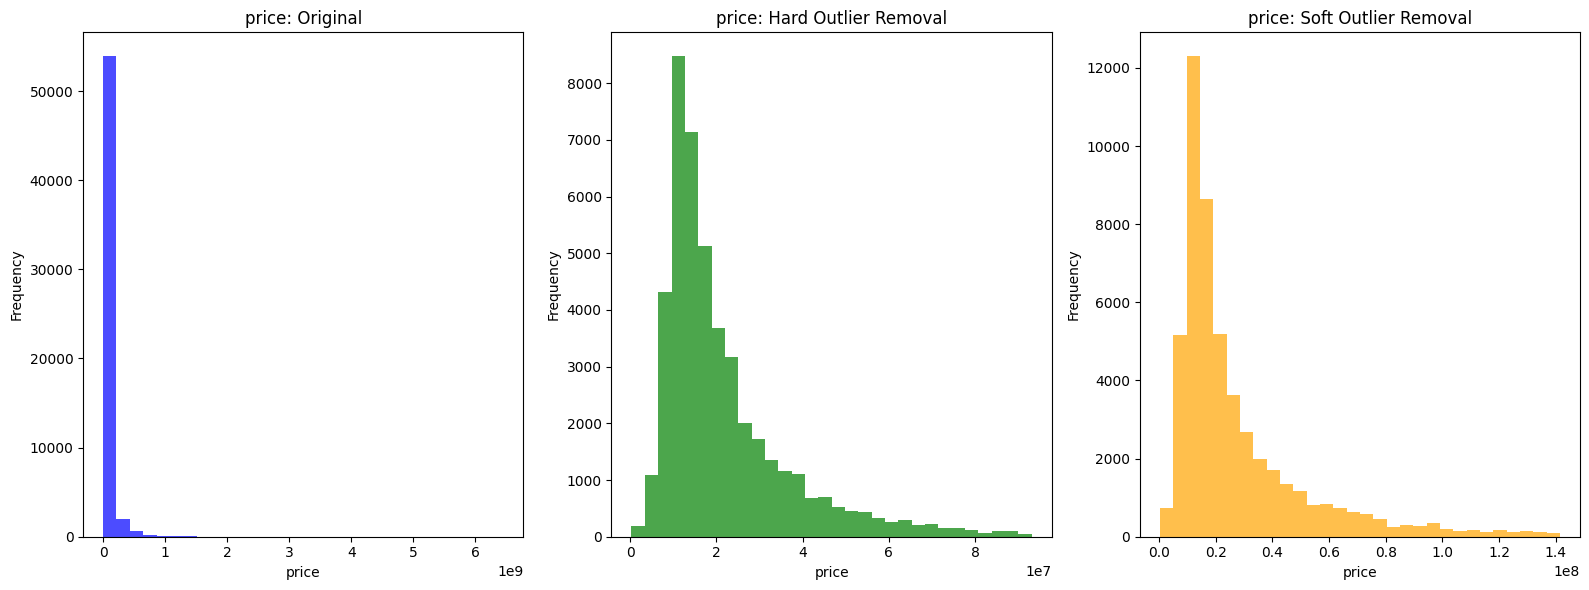

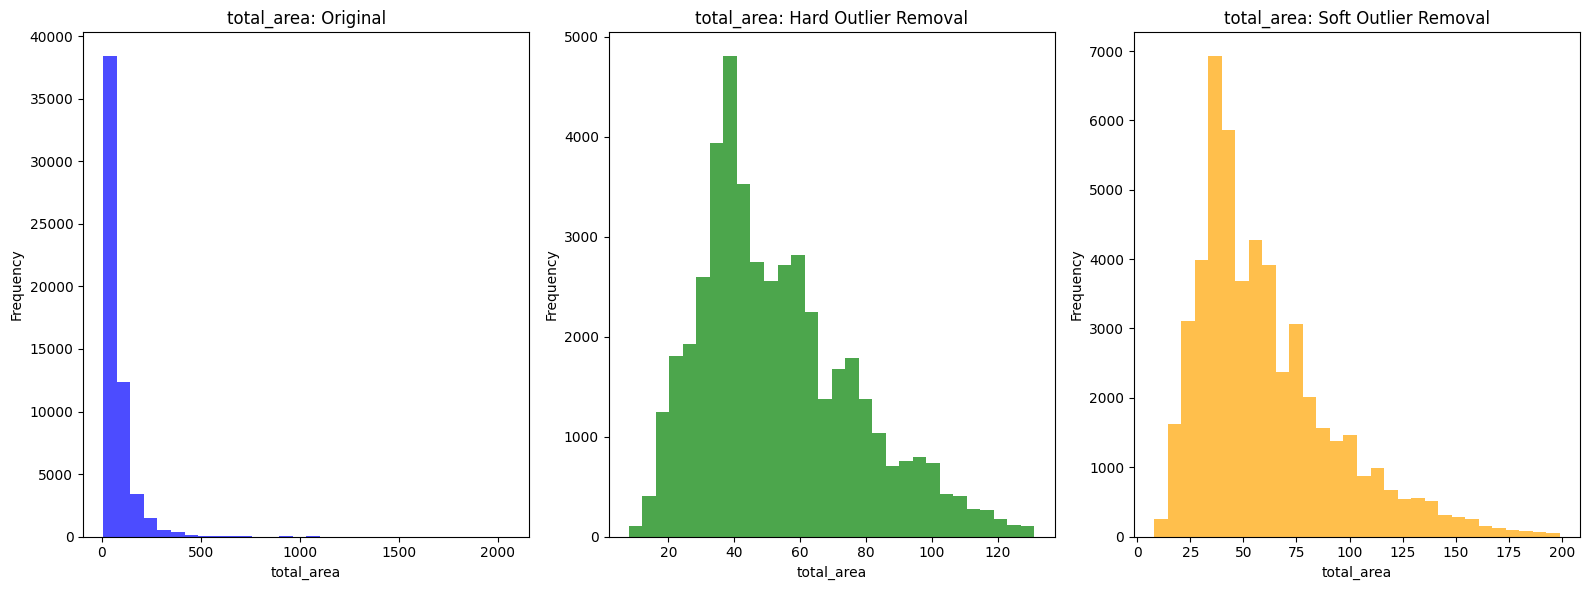

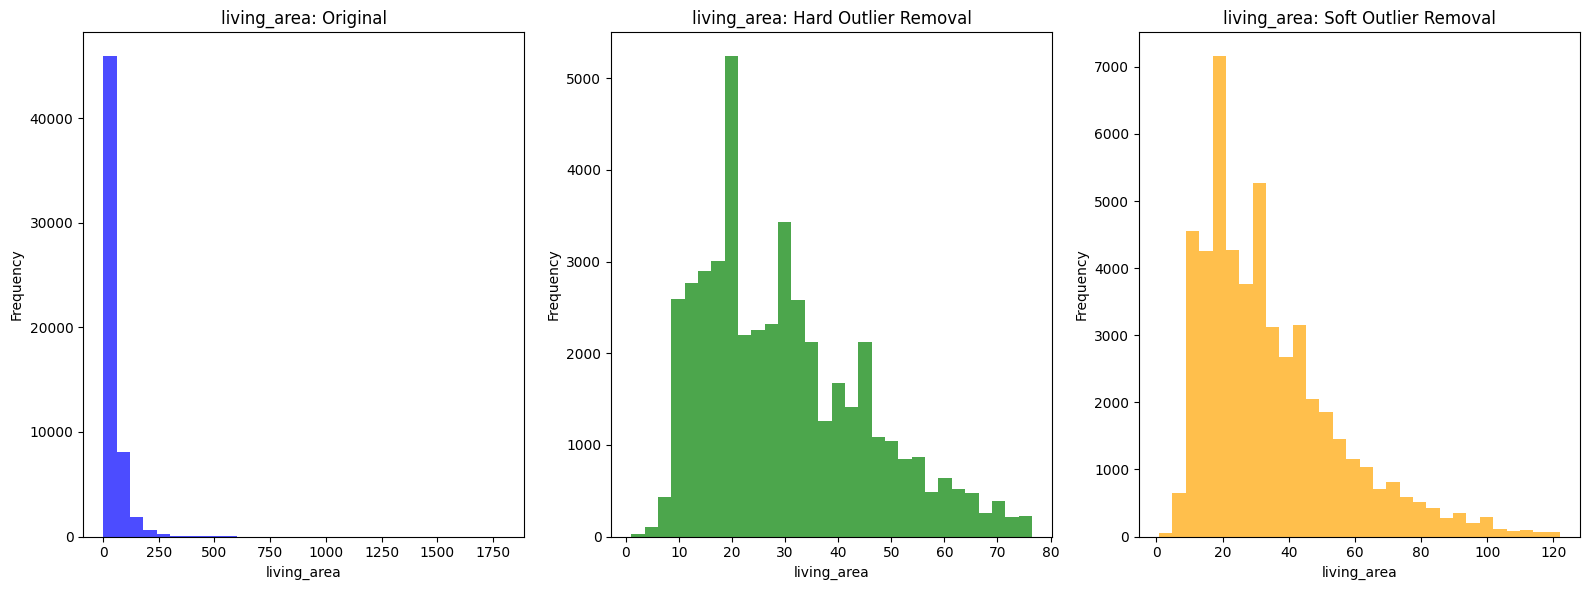

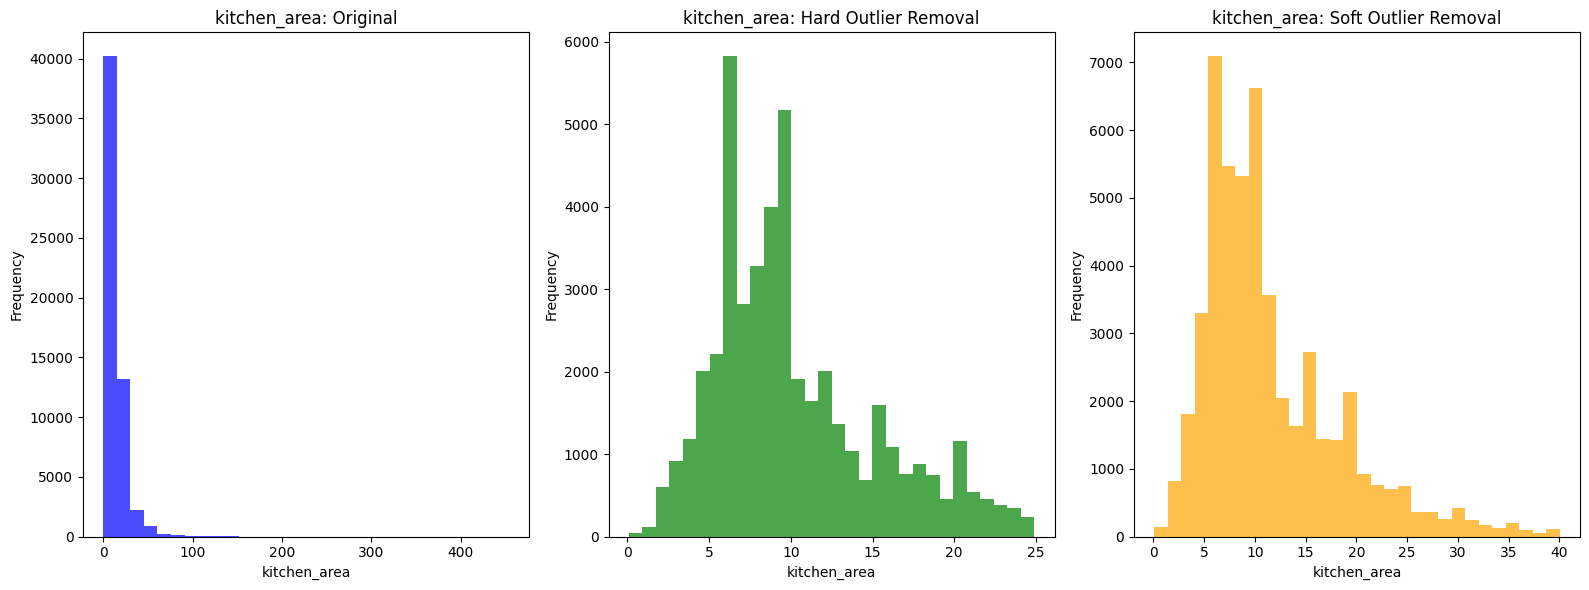

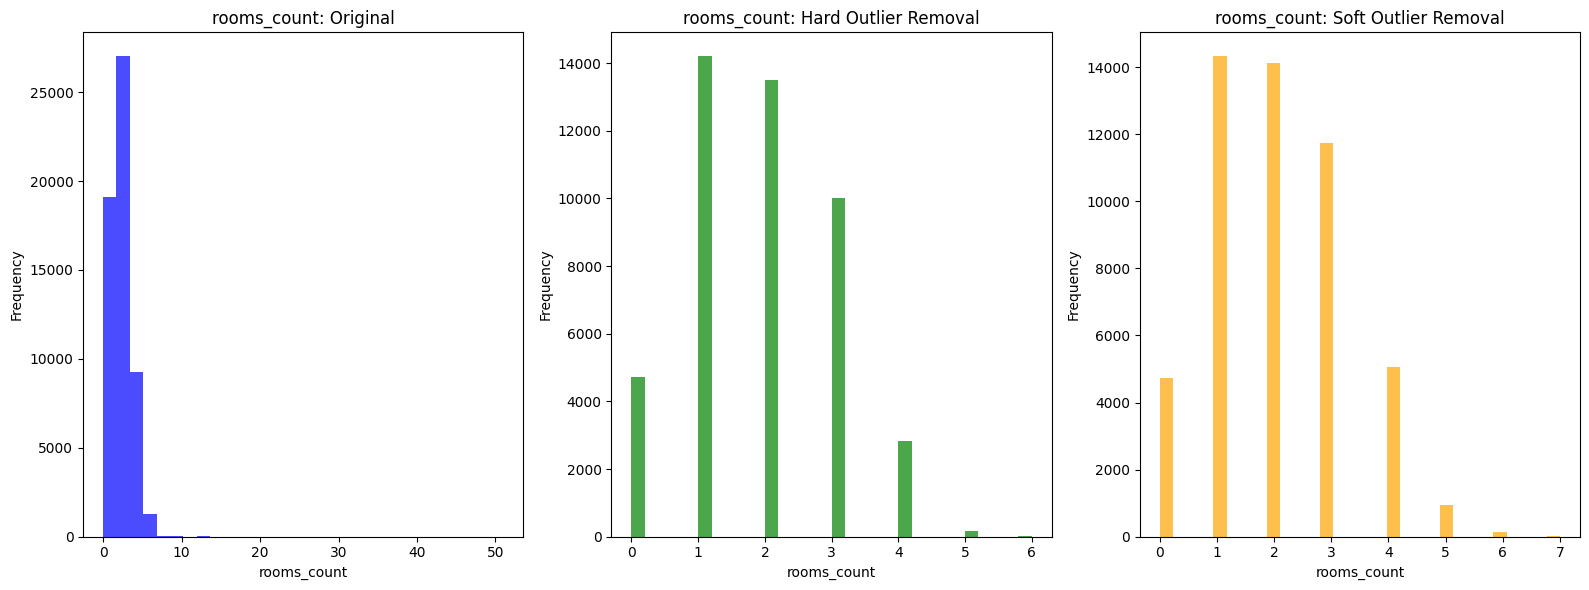

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def remove_outliers_hard(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliers_soft(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


columns_to_clean = ['price', 'total_area', 'living_area', 'kitchen_area', 'rooms_count']
df_cleaned = main_df.copy()
df_soft_cleaned = main_df.copy()

for column in columns_to_clean:
    df_cleaned = remove_outliers_hard(df_cleaned, column)
    df_soft_cleaned = remove_outliers_soft(df_soft_cleaned, column)

for column in columns_to_clean:
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.hist(main_df[column], bins=30, alpha=0.7, color='blue')
    plt.title(f'{column}: Original')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(df_cleaned[column], bins=30, alpha=0.7, color='green')
    plt.title(f'{column}: Hard Outlier Removal')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(df_soft_cleaned[column], bins=30, alpha=0.7, color='orange')
    plt.title(f'{column}: Soft Outlier Removal')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
# Информация о данных до и после очистки
print(f"\nДо очистки: {main_df.shape[0]} записей")
print(f"После очистки: {df_soft_cleaned.shape[0]} записей")


До очистки: 56902 записей
После очистки: 51066 записей


In [ ]:
df_soft_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51066 entries, 0 to 71091
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county                51066 non-null  object 
 1   district              51066 non-null  object 
 2   metro                 51066 non-null  object 
 3   travel_type           51066 non-null  object 
 4   travel_time           51066 non-null  int64  
 5   price                 51066 non-null  int64  
 6   category              51066 non-null  object 
 7   views_count           51066 non-null  int64  
 8   photos_count          51066 non-null  int64  
 9   floor_number          51066 non-null  int64  
 10  floors_count          51066 non-null  int64  
 11  flat_type             51066 non-null  object 
 12  sale_type             51066 non-null  object 
 13  review_count          51066 non-null  int64  
 14  total_rate            51066 non-null  float64
 15  project_type          51

In [ ]:
output_file_path = "dataset.csv"

try:
    df_soft_cleaned.to_csv(output_file_path, index=False, encoding='utf-8')
    print(f"DataFrame успешно сохранён в файл: {output_file_path}")
except NameError:
    print("DataFrame 'df_soft_cleaned' не найден. Убедитесь, что он существует.")
except Exception as e:
    print(f"Произошла ошибка при сохранении файла: {e}")

DataFrame успешно сохранён в файл: dataset.csv


# Кодирование

In [ ]:
X = df_soft_cleaned.drop(columns=['price'])  # Все столбцы, кроме 'price', будут признаками
y = df_soft_cleaned['price']  # Целевая переменная

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder, StandardScaler

# Onehot Encoding
onehot_columns = ['county', 'flat_type', 'sale_type', 'category', 'material_type', 'travel_type']
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_columns]), columns=onehot_encoder.get_feature_names_out(onehot_columns))
X_test_encoded = pd.DataFrame(onehot_encoder.transform(X_test[onehot_columns]), columns=onehot_encoder.get_feature_names_out(onehot_columns))
X_train = pd.concat([X_train.drop(columns=onehot_columns).reset_index(drop=True), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=onehot_columns).reset_index(drop=True), X_test_encoded], axis=1)

# Ordinal Encoding для столбцов с упорядоченными категориями
ordinal_columns = {'repair_type': {'no': 0, 'cosmetic': 1, 'euro': 2, 'design': 3}}
for col, mapping in ordinal_columns.items():
    X_train[col] = X_train[col].map(mapping)
    X_test[col] = X_test[col].map(mapping)

# Target Encoding для столбцов с большим количеством уникальных категорий
target_columns = ['district', 'project_type', 'metro']
target_encoder = TargetEncoder(target_type='continuous')

# Применяем Target Encoding для столбцов с небольшим количеством уникальных категорий
X_train[target_columns]= pd.DataFrame(target_encoder.fit_transform(X_train[target_columns], y_train), columns=target_columns)
X_test[target_columns]= pd.DataFrame(target_encoder.transform(X_test[target_columns]), columns=target_columns)

# Scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
X_train.shape, X_test.shape

((40076, 59), (10019, 59))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40076 entries, 0 to 40075
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   district                      40076 non-null  float64
 1   metro                         40076 non-null  float64
 2   travel_time                   40076 non-null  float64
 3   views_count                   40076 non-null  float64
 4   photos_count                  40076 non-null  float64
 5   floor_number                  40076 non-null  float64
 6   floors_count                  40076 non-null  float64
 7   review_count                  40076 non-null  float64
 8   total_rate                    40076 non-null  float64
 9   project_type                  40076 non-null  float64
 10  is_apartment                  40076 non-null  float64
 11  is_penthouse                  40076 non-null  float64
 12  is_mortgage_allowed           40076 non-null  float64
 13  i

# Выбор параметров

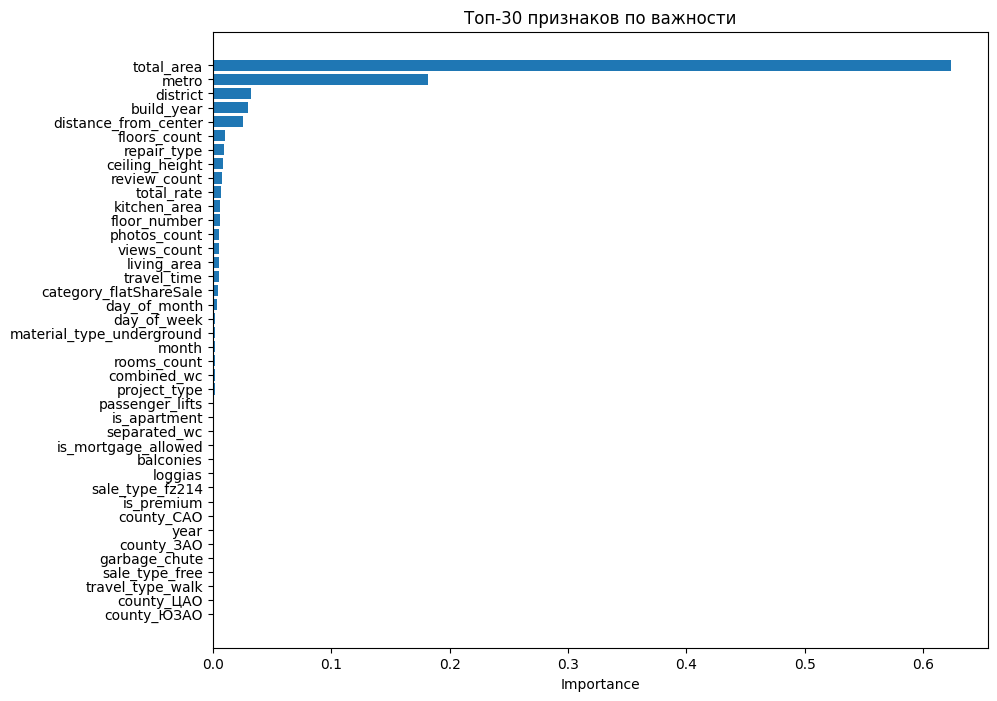

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Обучаем модель RandomForest для оценки важности признаков
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Получаем важности признаков
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Отбираем топ-30 признаков
top_features = feature_importances.head(40)

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.gca().invert_yaxis()
plt.title('Топ-30 признаков по важности')
plt.xlabel('Importance')
plt.show()

# Сохраняем список лучших признаков
selected_features = top_features['Feature'].tolist()


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Используем Ridge для отбора признаков
ridge = Ridge(alpha=1.0)
selector = RFE(estimator=ridge, n_features_to_select=40, step=1)
selector.fit(X_train, y_train)

# Отбираем лучшие признаки
selected_features = X_train.columns[selector.support_].tolist()
print(f"Выбранные признаки: {selected_features}")


Выбранные признаки: ['district', 'metro', 'travel_time', 'views_count', 'floor_number', 'floors_count', 'review_count', 'total_rate', 'project_type', 'is_apartment', 'is_mortgage_allowed', 'is_premium', 'renovation_programm', 'repair_type', 'total_area', 'living_area', 'kitchen_area', 'ceiling_height', 'loggias', 'rooms_count', 'separated_wc', 'combined_wc', 'build_year', 'distance_from_center', 'month', 'county_ЗАО', 'county_ЗелАО', 'county_СЗАО', 'county_ЦАО', 'county_ЮЗАО', 'flat_type_rooms', 'flat_type_studio', 'sale_type_dupt', 'sale_type_free', 'sale_type_fz214', 'category_flatShareSale', 'category_newBuildingFlatSale', 'material_type_multilevel', 'material_type_underground', 'travel_type_walk']


# **Обучение моделей**

**Модель LinearRegression**

---



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

model = LinearRegression()
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred)}
R2={r2_score(y_train, train_pred)}
mae={mean_absolute_error(y_train, train_pred)}
mape={mean_absolute_percentage_error(y_train, train_pred)}
''')
print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred)}
R2={r2_score(y_test, test_pred)}
mae={mean_absolute_error(y_test, test_pred)}
mape={mean_absolute_percentage_error(y_test, test_pred)}
''')

Metrics_train:
mse=99796556794458.98
R2=0.8243527946297118
mae=6353746.298359226
mape=0.2932314641225647

Metrics_test:
mse=104300603692044.22
R2=0.8211019127563621
mae=6475623.297127852
mape=0.29738681850177295



In [ ]:
coeff = pd.DataFrame(model.coef_, X_train.columns, columns=['coeff'])
coeff['coeff'].abs().sort_values(ascending=False).astype(int).head(10)

,coeff
total_area,15672261
metro,7100813
rooms_count,3431376
build_year,2705466
combined_wc,2065802
repair_type,1756976
floors_count,1713529
county_ЦАО,1458688
category_flatShareSale,1324679
material_type_underground,1224308


In [ ]:
model.intercept_

27315384.844645165

In [ ]:
coeff['coeff'].abs().sort_values(ascending=True).astype(int).head(20)

sale_type_investment           29267
material_type_underground      37076
material_type_roof             81432
material_type_multilevel      219378
garbage_chute                 227309
county_ТАО (Троицкий)         244893
category_flatShareSale        252775
passenger_lifts               362867
sale_type_dzhsk               450098
county_ЮВАО                   619891
review_count                  634552
ceiling_height                669808
county_СВАО                   675773
sale_type_pdkp                711999
day_of_month                  772001
kitchen_area                  856812
sale_type_dupt                971481
flat_type_studio             1056281
travel_time                  1090174
sale_type_fz214              1133913
Name: coeff, dtype: int64

**Модель RidgeCV**

---



In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

model_2 = RidgeCV(alphas=[0.001, 0.01, 0.5, 1, 10, 100, 1000, 10000, 25000, 50000, 100000], scoring='neg_mean_absolute_percentage_error')
model_2.fit(X_train, y_train)
train_pred_2 = model_2.predict(X_train)
test_pred_2 = model_2.predict(X_test)

print(f"Лучшее значение alpha: {model_2.alpha_}")

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_2)}
R2={r2_score(y_train, train_pred_2)}
mae={mean_absolute_error(y_train, train_pred_2)}
mape={mean_absolute_percentage_error(y_train, train_pred_2)}
''')
print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_2)}
R2={r2_score(y_test, test_pred_2)}
mae={mean_absolute_error(y_test, test_pred_2)}
mape={mean_absolute_percentage_error(y_test, test_pred_2)}
''')


Лучшее значение alpha: 25000.0
Metrics_train:
mse=124337947361942.9
R2=0.7811586523913432
mae=6619232.745765618
mape=0.28519133554791576

Metrics_test:
mse=130415349798160.7
R2=0.7763094766451428
mae=6744159.4365661
mape=0.2853700441179408



**Модель Ridge**

---

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

model_3 = Ridge()

model_3.fit(X_train, y_train)
train_pred_3 = model_3.predict(X_train)
test_pred_3= model_3.predict(X_test)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_3)}
R2={r2_score(y_train, train_pred_3)}
mae={mean_absolute_error(y_train, train_pred_3)}
mape={mean_absolute_percentage_error(y_train, train_pred_3)}
''')
print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_3)}
R2={r2_score(y_test, test_pred_3)}
mae={mean_absolute_error(y_test, test_pred_3)}
mape={mean_absolute_percentage_error(y_test, test_pred_3)}
''')


Metrics_train:
mse=99796559557336.45
R2=0.8243527897669017
mae=6353678.28399982
mape=0.29322660258189087

Metrics_test:
mse=104300689390810.39
R2=0.8211017657644483
mae=6475576.019827571
mape=0.2973795419517342



In [ ]:
coeff = pd.DataFrame(model_3.coef_, X_train.columns, columns=['coeff'])
coeff['coeff'].abs().sort_values(ascending=False).astype(int).head(10)

total_area      119834260
metro            33927883
rooms_count      21987663
living_area      21935903
build_year       12813807
floors_count      9180053
project_type      8771134
is_penthouse      8119985
county_ЗАО        7987157
views_count       7339171
Name: coeff, dtype: int64

**Модель LassoCV**

---

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer

model_4 = LassoCV(alphas=[0.01, 1, 10, 100, 1000, 10000, 25000, 50000, 100000], max_iter=10000, cv=5)
model_4.fit(X_train, y_train)

print(f"Лучшее значение alpha: {model_4.alpha_}")

train_pred_4 = model_4.predict(X_train)
test_pred_4 = model_4.predict(X_test)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_4)}
R2={r2_score(y_train, train_pred_4)}
mae={mean_absolute_error(y_train, train_pred_4)}
mape={mean_absolute_percentage_error(y_train, train_pred_4)}
''')
print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_4)}
R2={r2_score(y_test, test_pred_4)}
mae={mean_absolute_error(y_test, test_pred_4)}
mape={mean_absolute_percentage_error(y_test, test_pred_4)}
''')


Лучшее значение alpha: 1000.0
Metrics_train:
mse=99796717667758.89
R2=0.8243525114842161
mae=6352854.208279996
mape=0.29315946465278314

Metrics_test:
mse=104307661103291.94
R2=0.8210898077701163
mae=6474838.0400593635
mape=0.29731231497951144



In [ ]:
import numpy as np

def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

In [ ]:
smape(y_test, test_pred_4)


np.float64(81.69734229556974)

In [ ]:
coeff = pd.DataFrame(model_4.coef_, X_train.columns, columns=['coeff'])
coeff['coeff'].abs().sort_values(ascending=False).astype(int).head(10)

total_area      119086026
metro            33890491
rooms_count      21951028
living_area      21328756
build_year       12766199
floors_count      9084511
project_type      8757383
is_penthouse      8121751
county_ЗАО        7587872
views_count       7285479
Name: coeff, dtype: int64

**Модель SGDRegressor**

---

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

model_5 = SGDRegressor(max_iter=10000)
model_5.fit(X_train, y_train)

train_pred_5 = model_5.predict(X_train)
test_pred_5 = model_5.predict(X_test)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_5):.6f}
R2={r2_score(y_train, train_pred_5):.6f}
mae={mean_absolute_error(y_train, train_pred_5):.6f}
mape={mean_absolute_percentage_error(y_train, train_pred_5):.6f}
''')

print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_5):.6f}
R2={r2_score(y_test, test_pred_5):.6f}
mae={mean_absolute_error(y_test, test_pred_5):.6f}
mape={mean_absolute_percentage_error(y_test, test_pred_5):.6f}
''')

Metrics_train:
mse=1268425299434914447360.000000
R2=-2232494.450976
mae=1534803437.662057
mape=86.775954

Metrics_test:
mse=455465720241273896960.000000
R2=-781221.191166
mae=1326357475.823413
mape=79.827534



In [ ]:
coeff = pd.DataFrame(model_5.coef_, X_train.columns, columns=['coeff'])
coeff['coeff'].abs().sort_values(ascending=False).astype(int).head(10)

sale_type_dzhsk         43289256307
sale_type_investment    35884585183
is_emergency             9391690906
material_type_roof       9007137832
county_ЮЗАО               686066206
review_count              531111386
project_type              393628397
sale_type_fz214           377992073
total_area                355345494
distance_from_center      355341027
Name: coeff, dtype: int64

**Модель ElasticNetCV**

---

In [ ]:
from sklearn.linear_model import ElasticNetCV

elastic_model = ElasticNetCV(
    alphas=[0.001, 0.01, 0.5, 1, 10],
    l1_ratio=[0.2, 0.3, 0.5, 0.7, 0.8],
    max_iter=10000,
    cv=10,
)
elastic_model.fit(X_train, y_train)
train_pred_6 = elastic_model.predict(X_train)
test_pred_6 = elastic_model.predict(X_test)

print(f"Best alpha: {elastic_model.alpha_}")
print(f"Best l1_ratio: {elastic_model.l1_ratio_}\n")

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_6):.6f}
R2={r2_score(y_train, train_pred_6):.6f}
mae={mean_absolute_error(y_train, train_pred_6):.6f}
mape={mean_absolute_percentage_error(y_train, train_pred_6):.6f}
''')

print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_6):.6f}
R2={r2_score(y_test, test_pred_6):.6f}
mae={mean_absolute_error(y_test, test_pred_6):.6f}
mape={mean_absolute_percentage_error(y_test, test_pred_6):.6f}
''')

Best alpha: 0.001
Best l1_ratio: 0.8

Metrics_train:
mse=99796732673619.140625
R2=0.824352
mae=6353207.317851
mape=0.293193

Metrics_test:
mse=104301450821622.406250
R2=0.821100
mae=6475248.984605
mape=0.297329



**Модель LinearRegression + PCA**

---

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_7 = LinearRegression()
model_7.fit(X_train_pca, y_train)

train_pred_7 = model_7.predict(X_train_pca)
test_pred_7 = model_7.predict(X_test_pca)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, train_pred_7):.6f}
R2={r2_score(y_train, train_pred_7):.6f}
mae={mean_absolute_error(y_train, train_pred_7):.6f}
mape={mean_absolute_percentage_error(y_train, train_pred_7):.6f}
''')

print(f'''Metrics_test:
mse={mean_squared_error(y_test, test_pred_7):.6f}
R2={r2_score(y_test, test_pred_7):.6f}
mae={mean_absolute_error(y_test, test_pred_7):.6f}
mape={mean_absolute_percentage_error(y_test, test_pred_7):.6f}
''')

Metrics_train:
mse=121189071985254.078125
R2=0.786701
mae=7137083.394264
mape=0.335890

Metrics_test:
mse=127743515981502.765625
R2=0.780892
mae=7302622.098193
mape=0.341965



**Модель Ridge + GridSearchCV + PolynomialFeatures**

---

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    # ('scaler', StandardScaler()), он не нужен. данные уже скейлили
    ('ridge', Ridge(solver='svd', max_iter=10000))
])

# param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 25000, 35000, 100000],
#               'poly__degree': [1, 2]}
# уже запускали, лучшие снизу
param_grid = {'ridge__alpha': [25000],
              'poly__degree': [2]}

plm_model = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=3)
plm_model.fit(X_train, y_train)

polynom_model = plm_model.best_estimator_
y_train_polynom = polynom_model.predict(X_train)
y_test_polynom = polynom_model.predict(X_test)

print(f'''Metrics_train:
mse={mean_squared_error(y_train, y_train_polynom)}
R2={r2_score(y_train, y_train_polynom)}
mae={mean_absolute_error(y_train, y_train_polynom)}
mape={mean_absolute_percentage_error(y_train, y_train_polynom)}
''')
print(f'''Metrics_test:
mse={mean_squared_error(y_test, y_test_polynom)}
R2={r2_score(y_test, y_test_polynom)}
mae={mean_absolute_error(y_test, y_test_polynom)}
mape={mean_absolute_percentage_error(y_test, y_test_polynom)}
''')

KeyboardInterrupt: 

In [ ]:
poly_features = polynom_model.named_steps['poly'].get_feature_names_out(X_train.columns)
coeff = pd.DataFrame(polynom_model.named_steps['ridge'].coef_, poly_features, columns=['coeff'])
coeff['coeff'].abs().sort_values(ascending=False).head(10).astype(int)

metro total_area                   9876292
total_area                         5437754
metro kitchen_area                 5338676
total_area county_ЦАО              4900424
district total_area                4830489
living_area                        4486848
total_area^2                       4436844
views_count is_penthouse           3988824
total_area distance_from_center    3982291
distance_from_center               3853488
Name: coeff, dtype: int64

In [ ]:
coeff['coeff'].abs().sort_values(ascending=True).head(10).astype(int)

sale_type_dzhsk material_type_roof          0
is_emergency county_ТАО (Троицкий)          0
sale_type_investment material_type_roof     0
sale_type_dzhsk sale_type_investment        0
is_emergency material_type_roof             0
is_emergency sale_type_dzhsk                0
is_emergency sale_type_investment           0
is_emergency sale_type_pdkp                 0
sale_type_pdkp material_type_roof           1
county_ТАО (Троицкий) material_type_roof    1
Name: coeff, dtype: int64

In [ ]:
import pickle
with open('model.pickle', 'wb') as file:
    pickle.dump({
        'model': polynom_model,
        'onehot_encoder': onehot_encoder,
        'target_encoder': target_encoder,
        'scaler': scaler
    }, file)